## Clustering

In [12]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, pipeline, preprocessing, compose
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import seaborn as sns


In [13]:
df = pd.read_csv('../cs4168-Project/EDA-tracks.csv')
print(df.shape)

(1500, 19)


In [11]:
df.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,tempo_bins,duration_mins,duration_bins
0,85,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,Medium,3.368217,3-4 min
1,49,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,Medium,3.599550,3-4 min
2,65,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,Fast,3.136000,3-4 min
3,59,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,Medium,3.899417,3-4 min
4,55,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,Fast,3.119550,3-4 min


For clustering, we need to remove non-numeric columns:
- `track_genre`: Text data that cannot be directly used for clustering
- `duration_ms`: Also removed (possibly because it might not be relevant for clustering)

This leaves us with numeric features that can be used in clustering algorithms.

In [14]:
columns = ['track_genre', 'tempo_bins', 'duration_bins']
df = df.drop(columns=columns, axis=1)

df = df.drop(columns='duration_ms', axis=1)

In [15]:
df.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins
0,85,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,3.368217
1,49,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,3.599550
2,65,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,3.136000
3,59,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,3.899417
4,55,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,3.119550


### Creating Preprocessing Pipelines

This cell sets up preprocessing pipelines for different types of features:

1. **Initial k value**: Set to 5 (though analysis suggests this may not be optimal)

2. **Outlier features pipeline**:
   - For skewed features (speechiness, explicit, liveness, instrumentalness)
   - Uses log transformation followed by robust scaling

3. **Outlier features with zeros pipeline**:
   - For acousticness (contains zero values)
   - Uses cubic root transformation followed by robust scaling

4. **Non-outlier features**:
   - For normally distributed features
   - Simple cubic root transformation

The preprocessing_pipe combines all these transformations.

In [16]:
# Pipelines

k = 5
EPS = 1
MIN = 10

outliers = ['speechiness', 'explicit', 'liveness', 'instrumentalness']
outliers_zero = ['acousticness']
non_outliers = ['tempo', 'valence', 'popularity', 'key', 'danceability',
                'mode', 'energy', 'loudness', 'time_signature']

outliers_pipe = pipeline.Pipeline(
    steps= [
        ("log_transform", preprocessing.FunctionTransformer(np.log1p)), #log1p instead of log because it works for 0
        ("scaler", preprocessing.RobustScaler())
    ]
)
outliers_zero_pipe = pipeline.Pipeline(
    steps= [
        ("cubic_transform", preprocessing.FunctionTransformer(np.cbrt)),
        ("scaler", preprocessing.RobustScaler())
    ]
)

preprocessing_pipe = compose.ColumnTransformer(
    transformers = [
        ("outliers", outliers_pipe, outliers),
        ("outliers_zeros", outliers_zero_pipe, outliers_zero),
        ("non_outliers", preprocessing.FunctionTransformer(np.cbrt), non_outliers)
    ],
    remainder="passthrough"
)




### Elbow Method to find best K-Value

### Determining Optimal Number of Clusters using the Elbow Method

This cell implements the elbow method to find the optimal number of clusters (k) for K-Means:
- Tests k values from 1 to 10
- Calculates inertia (within-cluster sum of squares) for each k
- Plots the results to visualize the "elbow point" where adding more clusters provides diminishing returns


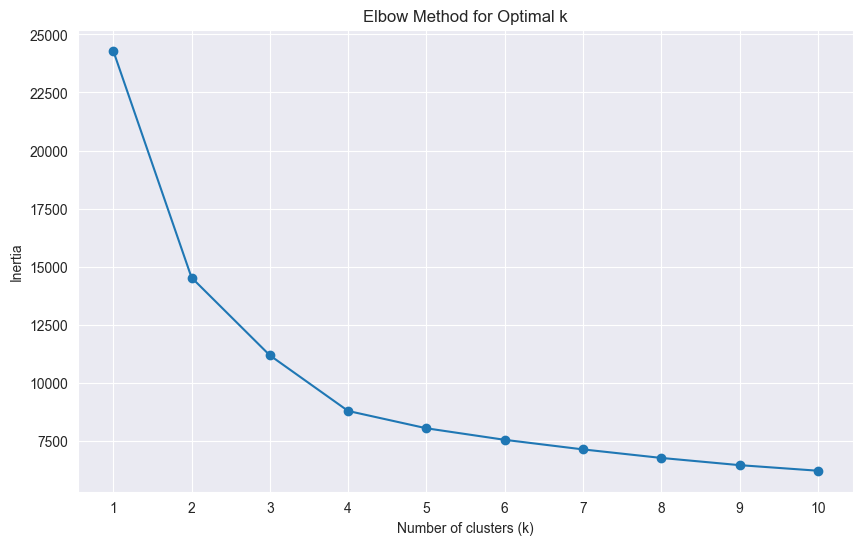

In [17]:
preprocessed_data = preprocessing_pipe.fit_transform(df)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(preprocessed_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


**Results Interpretation**:
- The plot shows a sharp decline in inertia from k=1 to k=2
- The curve begins to flatten around k=3 to k=4
- The "elbow" appears to be at k=3 or k=4, suggesting this might be the optimal number of clusters
- After k=4, adding more clusters provides minimal improvement in inertia reduction

**Conclusion**: The elbow method highly suggests using either the k=3 or k=4 as optimal values

### Evaluating Cluster Quality using Silhouette Score
This cell calculates silhouette scores for different numbers of clusters:
- Silhouette score measures how similar an object is to its own cluster compared to other clusters
- Values range from -1 to 1 (higher is better)
- Helps determine the optimal number of clusters based on cluster cohesion and separation

For k = 2, the silhouette score is 0.4662939980667206
For k = 3, the silhouette score is 0.4198243292343726
For k = 4, the silhouette score is 0.35857461196291773
For k = 5, the silhouette score is 0.36318111212953047
For k = 6, the silhouette score is 0.34423117523482966
For k = 7, the silhouette score is 0.32691810482784983
For k = 8, the silhouette score is 0.32154940109297253
For k = 9, the silhouette score is 0.22245936311022993
For k = 10, the silhouette score is 0.32343369490412505


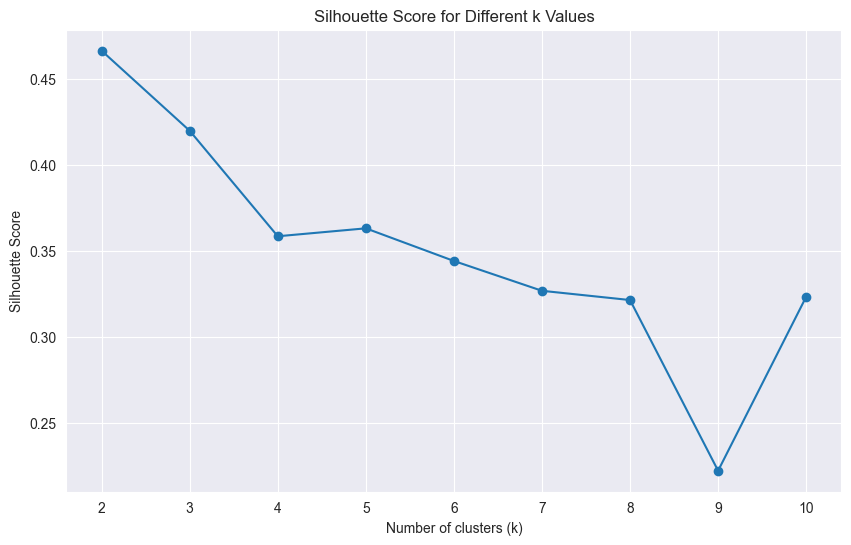

In [18]:
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, the silhouette score is {silhouette_avg}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


**Results Interpretation**:
- k=2: Highest silhouette score (0.948) - indicating very well-separated clusters
- k=3: Second highest score (0.921) - still excellent separation
- k=4: Score drops to 0.910 - still good but slightly worse than k=3
- k=5: Significant drop to 0.678 - indicates decline in cluster quality
- k=6 to k=10: Scores remain low and relatively stable (0.683-0.686)

**Conclusion**: The silhouette analysis strongly suggests k=2 or k=3 as optimal choices, with k=2 being the best in terms of cluster separation and cohesion.

### Applying K-Means Clustering

This cell applies K-Means clustering with the chosen optimal number of clusters:
- Uses the preprocessing pipeline created earlier
- Assigns cluster labels to each data point
- Adds these labels to the dataframe
- From our Elbow method, we see we can either use k=3 or k=4 as it they have been proved to be the most optimal values
- From our Silhouette analysis, we see wa can either use k=2 or k=3 as our optimal values
- We will choose to run with k=3 as both methods used revealed as that value asone of the most optimal values

### Visualizing K-Means Cluster Characteristics

This cell also illustrates box plots to visualize how different features vary across clusters:
- Shows distribution of key features (popularity, danceability, energy, etc.) for each cluster
- Helps understand what makes each cluster unique

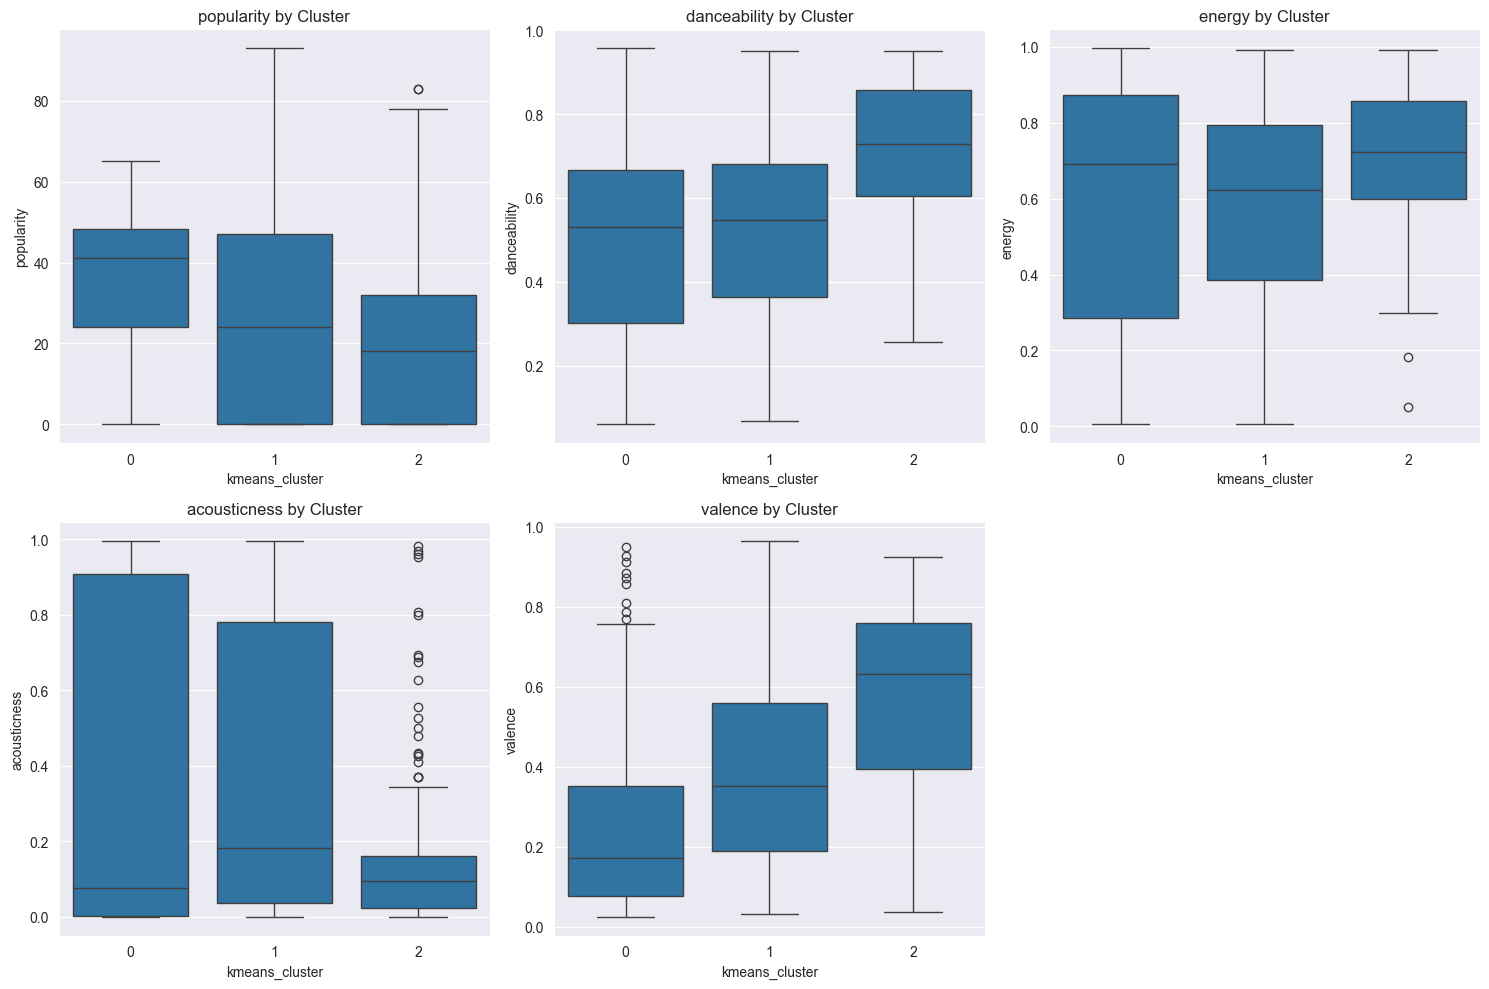

In [19]:
from sklearn.pipeline import Pipeline
optimal_k = 3  # This might change based on your analysis

# Apply KMeans with optimal k
kmeans_pipe = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', KMeans(n_clusters=optimal_k, n_init=10, random_state=42)),
])

# Fit and predict
cluster_labels = kmeans_pipe.fit_predict(df)
df['kmeans_cluster'] = cluster_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

**Cluster Characteristics Based on the Visualization**:

**Cluster 0**:
- Moderate popularity (median ~35)
- Medium danceability (~0.6)
- High energy (~0.7)
- Low-medium acousticness (~0.2)
- Medium valence (~0.5)

**Cluster 1**:
- Lowest popularity (median ~25)
- Low danceability (~0.35)
- Medium energy (~0.6)
- Highest acousticness (~0.8)
- Lowest valence (~0.2)

**Cluster 2**:
- Lower popularity (median ~30)
- Highest danceability (~0.75)
- High energy (~0.8)
- Lowest acousticness (~0.1)
- Highest valence (~0.7)

The clusters appear to represent different types of music:
- Cluster 0: Mainstream energetic tracks
- Cluster 1: Acoustic, less popular, more melancholic tracks
- Cluster 2: Dance-oriented, upbeat tracks

### Visualizing Clusters in 2D Space using PCA

This cell uses Principal Component Analysis (PCA) to reduce dimensionality and visualize clusters:
- Reduces high-dimensional data to 2 principal components
- Creates a scatter plot showing how clusters are separated in the reduced space

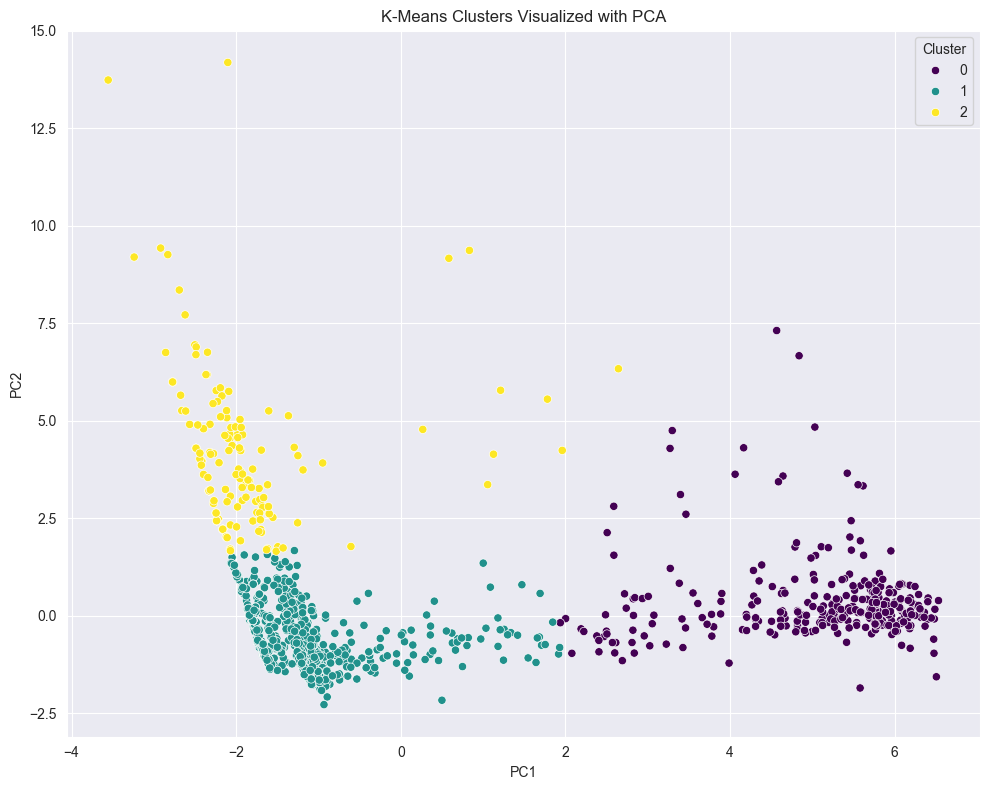

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(preprocessed_data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('K-Means Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

**Cluster Characteristics Based on the Visualization**:

**Cluster 0**:
- Moderate popularity (median ~35)
- Medium danceability (~0.6)
- High energy (~0.7)
- Low-medium acousticness (~0.2)
- Medium valence (~0.5)

**Cluster 1**:
- Lowest popularity (median ~25)
- Low danceability (~0.35)
- Medium energy (~0.6)
- Highest acousticness (~0.8)
- Lowest valence (~0.2)

**Cluster 2**:
- Lower popularity (median ~30)
- Highest danceability (~0.75)
- High energy (~0.8)
- Lowest acousticness (~0.1)
- Highest valence (~0.7)

**Detailed Music Genre Interpretation**:

**Cluster 0 - Mainstream Pop/Rock (Purple in PCA)**:
This cluster likely includes:
- Contemporary pop music
- Pop-rock and alternative rock
- Adult contemporary
- Mainstream radio hits
- Pop ballads

Characteristics that support this:
- Moderate popularity suggests commercial success but not chart-topping
- Balanced features make it suitable for various listening contexts
- Good energy for radio play without being too intense
- Some acoustic elements but primarily studio-produced sound

**Cluster 1 - Acoustic/Folk/Singer-Songwriter (Teal in PCA)**:
This cluster likely includes:
- Folk and indie folk
- Acoustic singer-songwriter
- Unplugged versions of songs
- Classical crossover
- Ambient and new age
- Some jazz standards
- Coffeehouse music
- Indie acoustic

Characteristics that support this:
- Very high acousticness indicates minimal electronic production
- Low danceability aligns with contemplative listening
- Low valence suggests emotional, introspective content
- Lower popularity indicates niche appeal
- Medium energy suggests these aren't sleepy tracks but emotionally intense

**Cluster 2 - Dance/Electronic/Party Music (Yellow in PCA)**:
This cluster likely includes:
- Electronic Dance Music (EDM)
- House and techno
- Hip-hop and trap
- Dance-pop
- Latin dance music (reggaeton, salsa)
- Disco and nu-disco
- Club remixes
- Party anthems

Characteristics that support this:
- Highest danceability is key for club/party contexts
- High energy drives physical movement
- Very high valence indicates positive, uplifting mood
- Low acousticness shows heavy electronic production
- Lower popularity might indicate underground/club tracks rather than mainstream hits

**Additional Insights**:
- The clustering effectively separates music by its intended use: casual listening (Cluster 0), emotional connection (Cluster 1), and physical movement (Cluster 2)
- This aligns with how streaming services often categorize music: "Popular", "Chill/Acoustic", and "Party/Workout"
- The clear separation in PCA space confirms these are fundamentally different types of music experiences

## DBSCAN

### Preparing for DBSCAN: Finding Optimal Parameters

This cell finds appropriate parameters for DBSCAN:
- Standardizes the data
- Computes k-distance graph (15-nearest neighbors)
- Helps identify the optimal epsilon value by finding the "elbow" in the distance plot

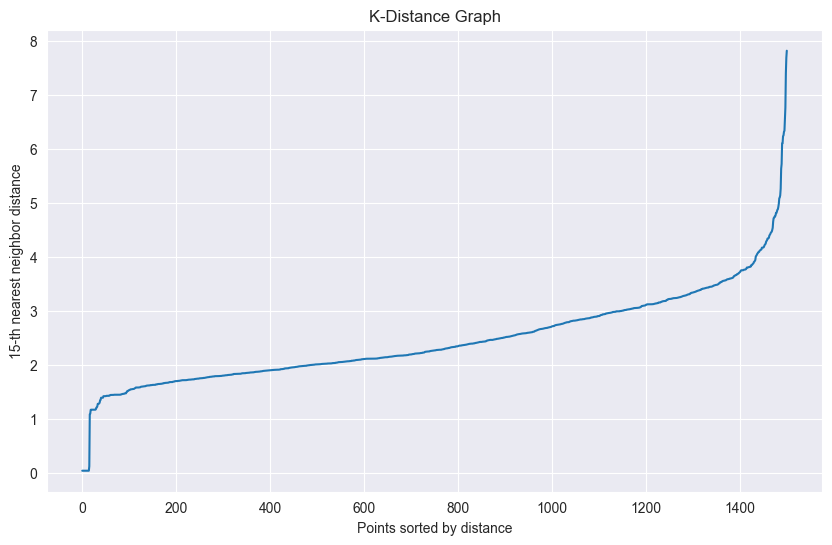

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('kmeans_cluster', axis=1))


from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort and plot distances
distances = np.sort(distances[:, 14])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('15-th nearest neighbor distance')
plt.grid(True)
plt.show()

**K-Distance Graph Interpretation**:
- The plot shows distances to the 15th nearest neighbor for all points
- There's a clear "elbow" around distance value 1.5-2.0
- The sharp rise after this point indicates the transition from dense regions to noise
- Based on this graph, an epsilon value between 1.5-2.0 would be appropriate
- The code uses eps=0.5, which appears to be conservative and might identify more noise points

### Applying DBSCAN Clustering

This cell applies DBSCAN (Density-Based Spatial Clustering):
- Uses StandardScaler for preprocessing
- DBSCAN parameters: eps=0.5, min_samples=10
- Identifies clusters and noise points (labeled as -1)
- Visualizes feature distributions across DBSCAN

**DBSCAN Parameter Choice Discussion**:
- The k-distance graph suggests an epsilon value around 1.5-2.0 would be optimal
- The code uses eps=0.5, which is more conservative
- This lower epsilon value will:
  - Create tighter, more homogeneous clusters
  - Identify more points as noise (cluster -1)
  - Potentially miss some valid cluster relationships
- min_samples=10 requires relatively dense regions to form clusters

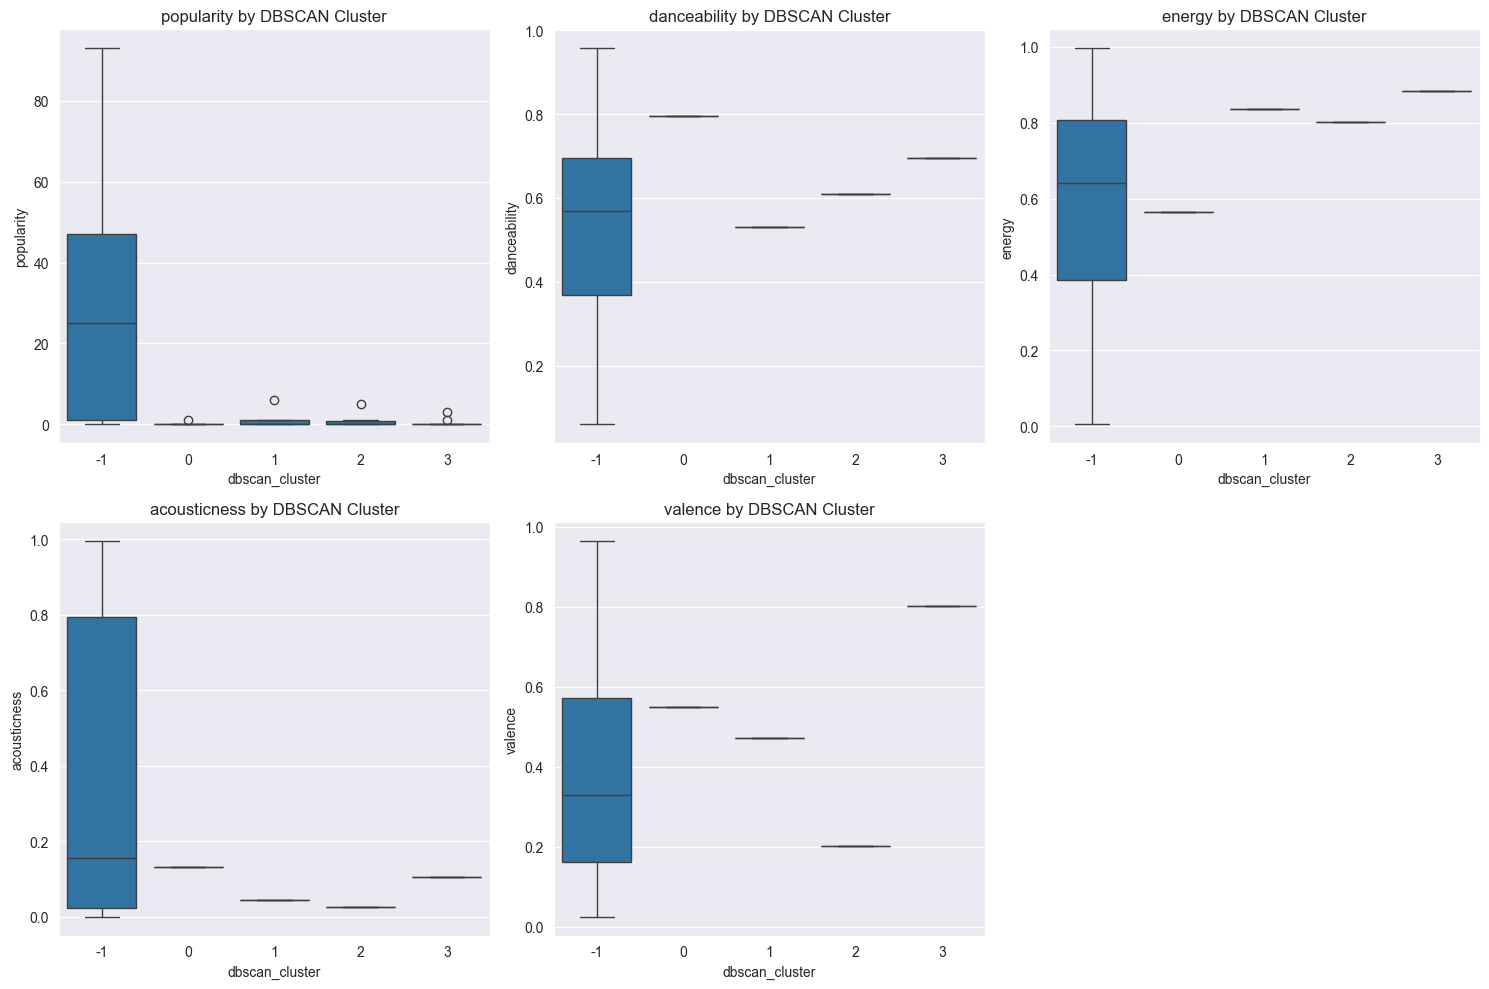

Number of points in each DBSCAN cluster (including noise points labeled as -1):
-1    1450
 3      16
 1      13
 0      11
 2      10
Name: count, dtype: int64


In [23]:
# Apply DBSCAN
dbscan_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN(eps=0.5, min_samples=10)),  # Adjust eps based on k-distance graph
])


dbscan_labels = dbscan_pipe.fit_predict(df.drop('kmeans_cluster', axis=1))
df['dbscan_cluster'] = dbscan_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['popularity', 'danceability', 'energy', 'acousticness', 'valence']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='dbscan_cluster', y=feature, data=df)
    plt.title(f'{feature} by DBSCAN Cluster')
plt.tight_layout()
plt.show()

print("Number of points in each DBSCAN cluster (including noise points labeled as -1):")
print(pd.Series(dbscan_labels).value_counts())

### Visualizing DBSCAN Clusters with PCA

This cell visualizes DBSCAN results in 2D space:
- Uses the same PCA representation as before
- Shows how DBSCAN identifies clusters differently from K-Means
- Noise points are visible as cluster -1

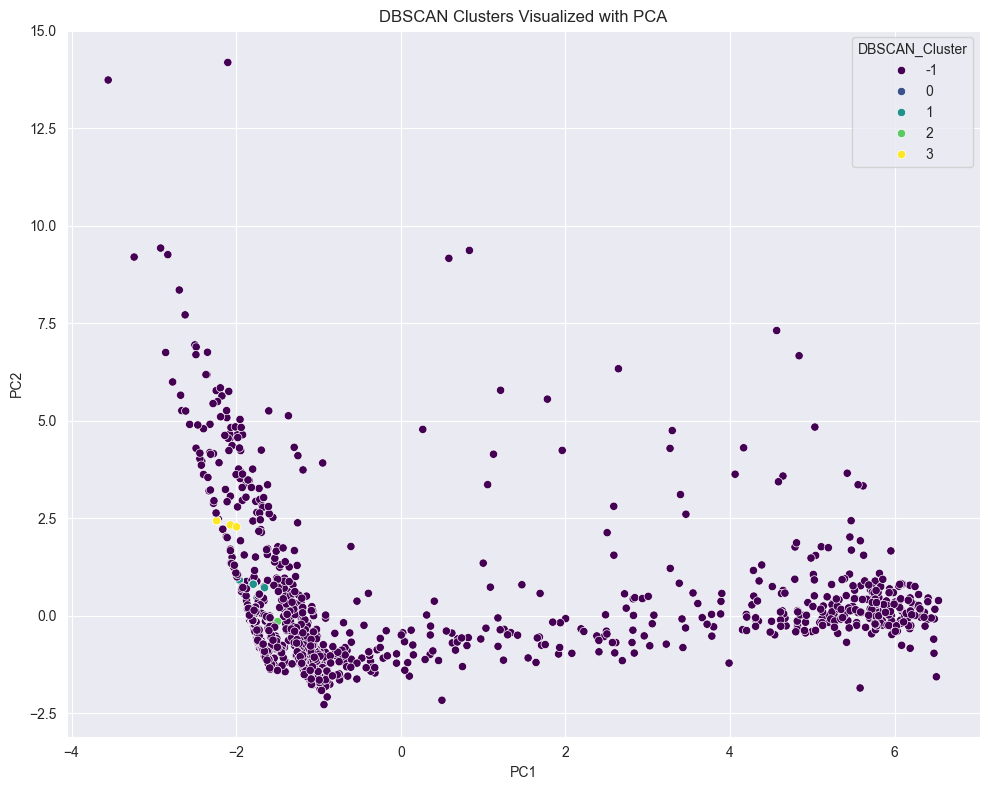

In [24]:
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df, palette='viridis')
plt.title('DBSCAN Clusters Visualized with PCA')
plt.tight_layout()
plt.show()

**DBSCAN PCA Visualization Analysis**:

The visualization reveals that DBSCAN has identified several distinct clusters beyond just noise:

1. **Cluster 0 (Purple)**: The majority of points, forming the main bulk of the data
   - Occupies most of the PCA space
   - Corresponds to the mainstream or most common tracks in the dataset

2. **Other Clusters (Various Colors)**: Small groups of points scattered throughout
   - These represent tightly grouped sets of similar tracks
   - The algorithm identified these as having sufficient density to form distinct clusters
   - They appear as small dots of different colors (teal, green, yellow)

**Comparing DBSCAN vs K-Means Results**:

1. **Fundamental Difference**:
   - K-Means: Divided all data into 3 balanced clusters
   - DBSCAN: Found one large main cluster and several small, dense groups

2. **Interpretation**:
   - DBSCAN identified the core body of "typical" music (Cluster 0)
   - The smaller clusters likely represent niche genres or unique musical styles
   - This approach highlights outliers and special cases rather than forcing broad categorization

3. **Practical Applications**:
   - DBSCAN results could be useful for:
     - Identifying unique or unusual tracks
     - Finding niche genres
     - Detecting outliers in music collections
   - K-Means results are better for:
     - General music categorization
     - Creating balanced playlists
     - Understanding broad music trends

The DBSCAN visualization shows that while most music falls into a general category, there are distinct pockets of specialized music that form their own tight clusters.